# Gaussian Process for Machine Learning 
## Gaussian prior and posterior using AIS data

- Implementation of "gaussian process for machine learning (M.Seeger, 2004)"
- Using **GPyTorch** module to test sample function with different kernels: Gardner, Jacob R., Geoff Pleiss, David Bindel, Kilian Q. Weinberger, and Andrew Gordon Wilson. ” GPyTorch: Blackbox Matrix-Matrix Gaussian Process Inference with GPU Acceleration.” In NeurIPS (2018). 

Implementation using AIS data
![img](result2/map.png) 

Focus on selected grid
![img](result2/matrix.png)

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd 
data = pd.read_csv('sample.csv')
data.head()

,x_value,y_value
0,0.396467,2.827151
1,1.138715,4.214562
2,1.542221,4.253028
3,0.712630,4.572318
4,0.726684,4.859688


In [3]:
train_x = torch.tensor(list(data['x_value']))
train_y = torch.tensor(list(data['y_value']))

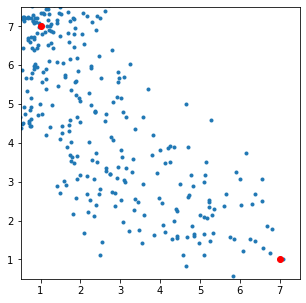

In [4]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(train_x.numpy(), train_y.numpy(), '.')
    ax.set_xlim([0.5, 7.5])
    ax.set_ylim([0.5, 7.5])
    ax.plot(1,7,'ro')
    ax.plot(7,1,'ro')

In [5]:
# We will use the simplest form of GP model, exact inference
class RBF_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(RBF_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale=1.0))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Matern_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Matern_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

class Linear_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Linear_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Periodic_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Periodic_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

class Polynomial_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Polynomial_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=4))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)       
    
    
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = RBF_GP_Model(train_x, train_y, likelihood)

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,8]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0.5, 7.5, 100)
    observed_pred = likelihood(model(test_x))

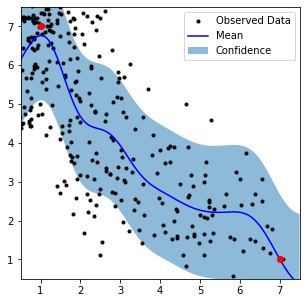

In [7]:
with torch.no_grad():
    # Initialize plot
    f1, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_xlim([0.5, 7.5])
    ax.set_ylim([0.5, 7.5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.plot(1,7,'ro')
    ax.plot(7,1,'ro')

In [8]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i%10 ==9:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()
print("\n", loss.item())

Iter 10/100 - Loss: 1.534   lengthscale: 1.161   noise: 1.158
Iter 20/100 - Loss: 1.528   lengthscale: 1.315   noise: 1.319
Iter 30/100 - Loss: 1.516   lengthscale: 1.098   noise: 1.155
Iter 40/100 - Loss: 1.511   lengthscale: 0.847   noise: 1.062
Iter 50/100 - Loss: 1.508   lengthscale: 0.618   noise: 1.099
Iter 60/100 - Loss: 1.507   lengthscale: 0.586   noise: 1.095
Iter 70/100 - Loss: 1.506   lengthscale: 0.648   noise: 1.078
Iter 80/100 - Loss: 1.506   lengthscale: 0.687   noise: 1.095
Iter 90/100 - Loss: 1.506   lengthscale: 0.666   noise: 1.095
Iter 100/100 - Loss: 1.506   lengthscale: 0.661   noise: 1.087

 1.5059785842895508


In [9]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0.5, 7.5, 100)
    observed_pred = likelihood(model(test_x))

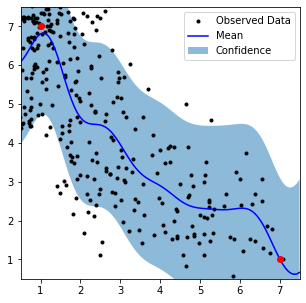

In [10]:
with torch.no_grad():
    # Initialize plot
    f2, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_xlim([0.5, 7.5])
    ax.set_ylim([0.5, 7.5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.plot(1,7,'ro')
    ax.plot(7,1,'ro')

In [11]:
#f1.savefig('result/posterior-RBF.png')
f2.savefig('result2/posterior(trained)-RBF.png')

## Results

| Dirichlet Baseline | Gaussian Posterior | 
|:------:|:------:|
| ![img](result2/matrix.png) | ![img](result2/posterior(trained)_RBF.png) | 

### references
- Bishop's Pattern Recognition and Machine Learning: http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf
- Basic code: https://gpytorch.readthedocs.io
- Gaussian Distribution: http://norman3.github.io/prml/docs/chapter02/0